# Udacity Machine Learning Nanodegree
--------------


## Capstone Project on Vehicle-Detection
---------------


### Parameter tuning in Neural Network

#### Imports

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time 
from sklearn.svm import LinearSVC

In [2]:
import pickle
%matplotlib inline

--------

### Classifier

#### Extraction of all required features

In [3]:
cars = glob.glob('data/vehicles/**/*.png')
notcars = glob.glob('data/non-vehicles/**/*.png')

In [4]:
# Reduce the sample size because HOG features are slow to compute
sample_size = 8000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

#### Parameters

In [5]:
colorspace = 'YCrCb'  #'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
hist_bins = 32
hist_bins_range = (0,256)
spatial_size = (32,32)

In [6]:
from project.feature_extraction import FeatureExtraction

In [7]:
t=time.time()

FE = FeatureExtraction(hist_bins = hist_bins,\
                            hist_bins_range =  hist_bins_range,\
                            spatial_size = spatial_size,\
                            orient = orient,\
                            pix_per_cell =  pix_per_cell,\
                            cell_per_block =  cell_per_block)


color_car_features = FE.extract_color_features(cars,
                                               cspace=colorspace)
color_notcar_features = FE.extract_color_features(notcars,
                                                cspace=colorspace)

hog_car_features = FE.extract_hog_features(cars,
                                    cspace=colorspace,
                                    hog_channel=hog_channel)

hog_notcar_features = FE.extract_hog_features(notcars,
                                       cspace=colorspace,
                                       hog_channel=hog_channel)

t2 = time.time()

print(round(t2-t, 2), 'Seconds to extract HOG features and color features...')


/Users/dibakarsigdel/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


127.69 Seconds to extract HOG features and color features...


#### Stacking all feature to single vector

In [8]:
# Create an array stack of feature vectors
X_car = np.hstack((color_car_features,hog_car_features)).astype(np.float64)
X_notcar = np.hstack((color_notcar_features, hog_notcar_features)).astype(np.float64) 
X = np.vstack((X_car,X_notcar)).astype(np.float64) 

X_scalar = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scalar.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(hog_car_features)), np.zeros(len(hog_notcar_features))))

In [9]:
scaled_X.shape

(16000, 6156)

#### Train and test split

In [10]:
from sklearn.utils import shuffle

scaled_X, y = shuffle(scaled_X, y )

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156


-------

### Neural Networks

In [11]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout
import os

Using TensorFlow backend.


In [12]:
import pandas as pd

------

In [13]:
input_dim = X_train.shape[1]
input_dim

6156

In [14]:
y_train = np_utils.to_categorical(y_train)

In [15]:
num_classes = y_train.shape[1]
num_classes

2

In [16]:
model = Sequential()

model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.15))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.15))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.15))

model.add(Dense(8, activation='relu'))
model.add(Dropout(0.15))

model.add(Dense(num_classes, activation='softmax'))


In [17]:
# we'll use categorical xent for the loss, and RMSprop as the optimizer
model.compile(loss='categorical_crossentropy',\
              optimizer='rmsprop',\
              metrics=['accuracy'])

In [18]:
print("Training...")
history = model.fit(X_train,\
          y_train,\
          nb_epoch=100,\
          batch_size=32,\
          validation_split=0.1,\
          verbose=2)

Training...


/Users/dibakarsigdel/anaconda/envs/carnd-term1/lib/python3.5/site-packages/keras/models.py:834: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 11520 samples, validate on 1280 samples
Epoch 1/100
12s - loss: 0.1070 - acc: 0.9648 - val_loss: 0.0355 - val_acc: 0.9906
Epoch 2/100
5s - loss: 0.0296 - acc: 0.9917 - val_loss: 0.0446 - val_acc: 0.9922
Epoch 3/100
5s - loss: 0.0209 - acc: 0.9952 - val_loss: 0.0563 - val_acc: 0.9922
Epoch 4/100
5s - loss: 0.0136 - acc: 0.9965 - val_loss: 0.0604 - val_acc: 0.9953
Epoch 5/100
5s - loss: 0.0144 - acc: 0.9970 - val_loss: 0.0586 - val_acc: 0.9914
Epoch 6/100
5s - loss: 0.0115 - acc: 0.9974 - val_loss: 0.0463 - val_acc: 0.9953
Epoch 7/100
5s - loss: 0.0083 - acc: 0.9964 - val_loss: 0.0383 - val_acc: 0.9961
Epoch 8/100
5s - loss: 0.0086 - acc: 0.9970 - val_loss: 0.0512 - val_acc: 0.9953
Epoch 9/100
7s - loss: 0.0107 - acc: 0.9981 - val_loss: 0.0316 - val_acc: 0.9977
Epoch 10/100
8s - loss: 0.0099 - acc: 0.9973 - val_loss: 0.0875 - val_acc: 0.9930
Epoch 11/100
8s - loss: 0.0065 - acc: 0.9984 - val_loss: 0.0436 - val_acc: 0.9953
Epoch 12/100
5s - loss: 0.0073 - acc: 0.9984 - val_loss: 

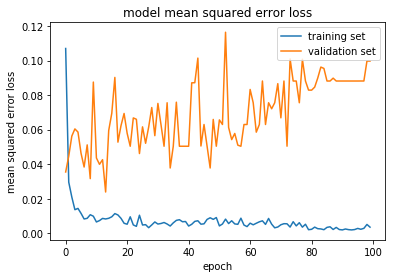

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [21]:
model.save("model.h5")

In [22]:
print("Generating test predictions...")
preds = model.predict_classes(X_test, verbose=0)

def write_preds(preds, fname):
    pd.DataFrame({"Id": list(range(1,len(preds)+1)),"true-level": y_test, "pLabel": preds}).to_csv(fname, index=False, header=True)

write_preds(preds, "keras-mlp.csv")

Generating test predictions...


In [23]:
test = pd.read_csv("keras-mlp.csv")

In [24]:
test.head(5)

,Id,pLabel,true-level
0,1,1,1.0
1,2,0,0.0
2,3,0,0.0
3,4,1,1.0
4,5,1,1.0


In [30]:
np.sum(test['pLabel'] == test['true-level'])

3174

In [31]:
test.shape

(3200, 3)

In [32]:
accuracy = 3174/3200
accuracy

0.991875

------

In [25]:
import pickle as pickle
pickle_dict = {}
pickle_dict["scalar"] = X_scalar
pickle_dict["orient"] = orient 
pickle_dict["pix_per_cell"]= pix_per_cell 
pickle_dict["cell_per_block"]= cell_per_block 
pickle_dict["spatial_size"]= spatial_size 
pickle_dict["hist_bins"]= hist_bins 

In [26]:
pickle_dict

{'cell_per_block': 2,
 'hist_bins': 32,
 'orient': 9,
 'pix_per_cell': 8,
 'scalar': StandardScaler(copy=True, with_mean=True, with_std=True),
 'spatial_size': (32, 32)}

In [27]:
with open('nn_pickle.p', mode='wb') as f:
    pickle.dump(pickle_dict, f)

------